Let's look step-by-step how we can generate these polygon backgrounds.

# Generating points

In [1]:
import numpy as np
from random import random
from math import floor
import matplotlib.pyplot as plt

In [2]:
# Variables
graphWidth = 1920
graphHeight = 1080
bleedX = 200
bleedY = 200
cellSize = 190
variance = 50
randomFunction = random
color_steps = 20

In [3]:
def gen_grid(w, h, b_x, b_y, cell_size, variance, rand_fn):
    """ Calculates random 2d dot array

    Keyword Arguments:
    w         -- width of grid
    h         -- height of grid
    b_x       -- bleed in the x dimmension
    b_y       -- bleed in the y dimmension
    cell_size -- size of each triangle cell
    variance  -- variance in each placement
    rand_fn   -- function to generate random numbers
    """

    w = w + b_x
    h = h + b_y
    half_cell = cell_size * 0.5

    points = []
    cell_size = int(cell_size)
    for i in range(-b_x, w, cell_size):
        for j in range(-b_y, h, cell_size):
            x = floor((i + half_cell) + (rand_fn() * variance*2 - variance))
            y = floor((j + half_cell) + (rand_fn() * variance*2 - variance))
            points.append([int(x), int(y)])

    return np.array(points)

In [4]:
samplePoints = gen_grid(graphWidth, graphHeight, bleedX, bleedY, cellSize, variance, randomFunction)

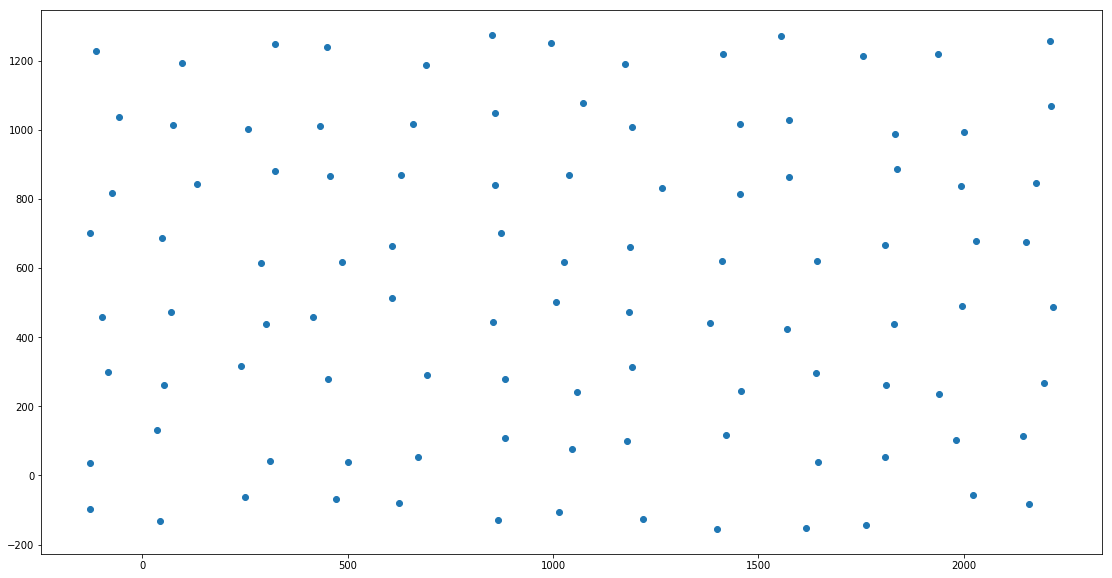

In [5]:
fig = plt.figure(figsize=(19,10))
plt.scatter(samplePoints[:,0], samplePoints[:,1])

In [6]:
from scipy.spatial import Delaunay
from skimage.draw import polygon

In [7]:
tri = Delaunay(samplePoints).simplices

In [8]:
tri[0]

array([ 79,  95, 103], dtype=int32)

In [9]:
from matplotlib.patches import Polygon

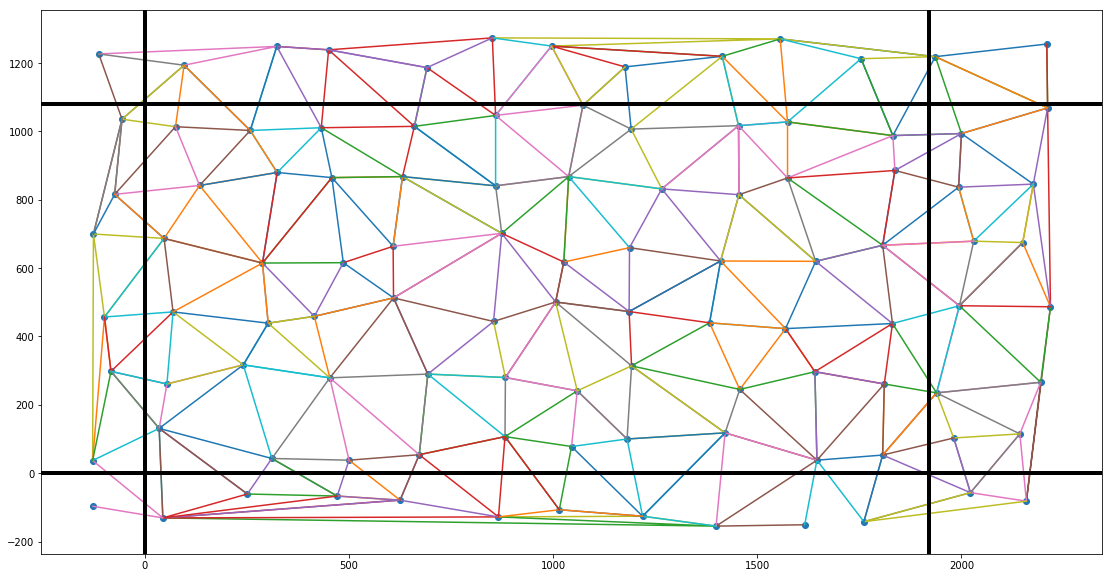

In [10]:
fig = plt.figure(figsize=(19,10))
for point in samplePoints[tri]:
        #print(tri)
        c = point[:, 0]
        r = point[:, 1]
        plt.plot(c,r)        
plt.scatter(samplePoints[:,0], samplePoints[:,1])

plt.axhline(y=0, color="black", linewidth=4)
plt.axvline(x=0, color="black", linewidth=4)
plt.axhline(y=graphHeight, color="black", linewidth=4)
plt.axvline(x=graphWidth, color="black", linewidth=4)

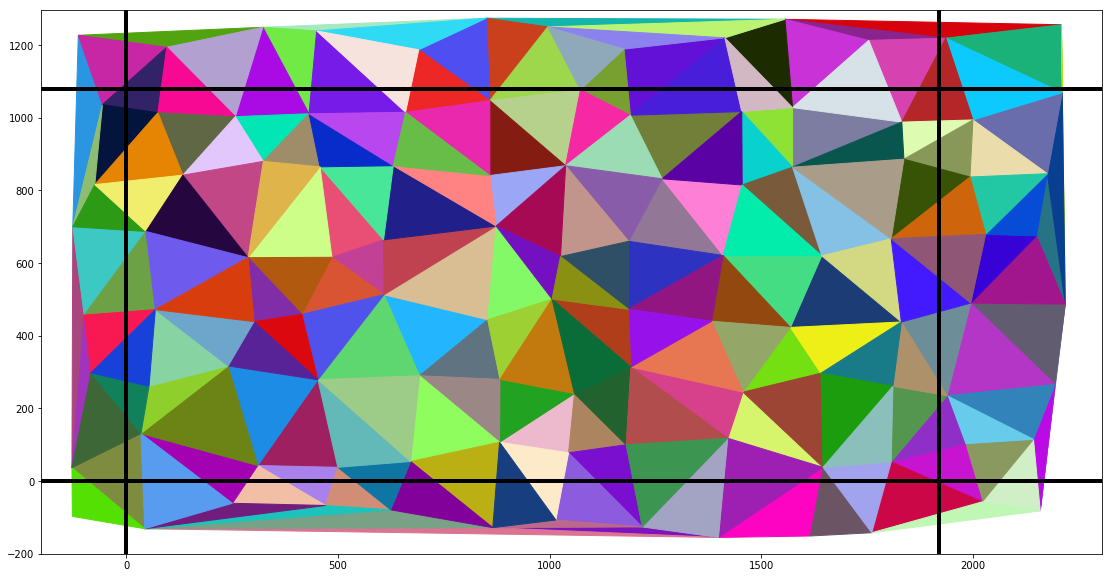

In [11]:
fig = plt.figure(figsize=(19,10))

ax = plt.gca()

for point in samplePoints[tri]:
        p = Polygon(point, closed=True, color=[random(),random(),random(),1])
        ax.add_patch(p)
        
#plt.scatter(samplePoints[:,0], samplePoints[:,1])
ax.set_xlim(-200,graphWidth*1.2)
ax.set_ylim(-200,graphHeight*1.2)

plt.axhline(y=0, color="black", linewidth=4)
plt.axvline(x=0, color="black", linewidth=4)
plt.axhline(y=graphHeight, color="black", linewidth=4)
plt.axvline(x=graphWidth, color="black", linewidth=4)

In [ ]:
def normalX(OldValue):
    """ Remaps X location to percentage

    Keyword Arguments:
    OldValue -- Integer Value to remap. Within (-BLEED_X, BLEED_X + size[0])
    """
    return max(0, remap(OldValue, -bleedX, graphWidth + bleedX, 0.0, 1.0))

In [ ]:
def normalY(OldValue):
    """ Remaps Y location to percentage

    Keyword Arguments:
    OldValue -- Integer Value to remap. Within(-BLEED_Y to BLEED_Y + size[0])
    """
    return max(0, remap(OldValue, -bleedY, graphHeight + bleedY, 0.0, 1.0))

In [ ]:
from colour import Color

In [ ]:
color_steps = 20

first_c = Color("#febf01")
second_c = Color("#ff02f6")
third_c = Color("#444444")
fourth_c = Color("#ffffff")

bitmapPhoto = np.zeros((graphWidth,graphHeight,3), 'uint8')


In [ ]:
def calculate_gradient(startcolor, endcolor, transition_steps):
    """ Calculates gradient from startcolor to endcolor with transition_steps

    Keyword Arguments:
    startcolor       -- an rgb tuple of the color to start with
    endcolor         -- an rgb tuple of the color to end with
    transition_steps -- number of colors to end up with total. Must be > 3
    """

    gradient = []
    sr, sg, sb = startcolor
    dr = (endcolor[0] - sr)/(transition_steps-1)
    dg = (endcolor[1] - sg)/(transition_steps-1)
    db = (endcolor[2] - sb)/(transition_steps-1)
    cr, cg, cb = sr, sg, sb
    for r in range(transition_steps):
        gradient.append((cr, cg, cb))
        cr += dr
        cg += dg
        cb += db
        cr = max(min(cr, 255), 0)
        cg = max(min(cg, 255), 0)
        cb = max(min(cb, 255), 0)
    return gradient

In [ ]:
gradi_X = calculate_gradient(first_c.rgb, second_c.rgb, color_steps)
gradi_Y = calculate_gradient(third_c.rgb, fourth_c.rgb, color_steps)

In [ ]:
def centerX(tri):
    """ Calculates X center of a triangle.

    Keyword Arguments:
    tri -- a 2x3 array where each element is a coord of the triangle
    """
    return (tri[0][0] + tri[1][0] + tri[2][0]) / 3


def centerY(tri):
    """ Calculates Y center of a triangle.

    Keyword Arguments:
    tri -- a 2x3 array where each element is a coord of the triangle
    """
    return (tri[0][1] + tri[1][1] + tri[2][1]) / 3

In [ ]:
def remap(OldValue, OldMin, OldMax, NewMin, NewMax):
    """ Preforms a linear remap of OldValue from an OldRange to a New Range
    Keyword Arguments:
    OldValue -- Value to remap
    OldMin   -- Minimum value of old range
    OldMax   -- Maximum value of old range
    NewMin   -- Minimum value of new range
    NewMax   -- Maximum value of new range
    """
    return (((OldValue - OldMin) * (NewMax - NewMin)) /
            (OldMax - OldMin)) + NewMin

def rgbMap(OldValue):
    """ Remaps color percentage (0-1 value) to 8 bit values

    Keyword Arguments:
    OldValue -- Integer Value to remap. Should be from 0 to 1
    """
    return remap(OldValue, 0, 1, 0, 255)

In [ ]:
for i in samplePoints[tri]:
        currentX = int(normalX(centerX(i)*color_steps))
        currentY = int(normalY(centerY(i)*color_steps))
        xColor, yColor = gradi_X[currentX], gradi_Y[currentY]
        intColor = calculate_gradient(xColor, yColor, 3)[1]
        colorChoice = tuple(rgbMap(intC) for intC in intColor)
        c = i[:, 0]
        r = i[:, 1]
        rr, cc = polygon(r, c)
        rr = np.clip(rr, 0, graphHeight-1)
        cc = np.clip(cc, 0, graphWidth-1)
        print(rr,cc)
        bitmapPhoto[cc, rr] = colorChoice